In [1]:
import sklearn
import sys
import pandas as pd
import numpy as np
import math

# 数据读取
参考：https://blog.csdn.net/iteapoy/article/details/105477848

In [2]:
np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# 把csv文件转换成numpy的数组
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


## 数据处理 标准化

$$\frac{x-mean}{std}$$

In [3]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # 按列对X进行标准化
    # 返回均值和标准差
    #
    # 声明:
    #     X: 待处理的数据
    #     train: 'True' 表示处理training data, 'False'表示 testing data
    #     specific_column: 需要被标准化的列索引
    #     X_mean: training data 均值, train = 'False'时用到
    #     X_std: training data 标准差, train = 'False'时用到
    # 输出:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

In [4]:
#标准化训练数据和测试数据
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [5]:
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)
np.save('X_test.npy', X_test)

In [97]:
X_train=np.load('X_train.npy')
Y_train=np.load('Y_train.npy')

In [98]:
X_train.shape
dim=X_train.shape[1]

# Generative model
生成模型
对训练集$\left(x^{1}, \hat{y}^{1}\right)\quad\left(x^{2}, \hat{y}^{2}\right) \quad \cdots \cdots \quad\left(x^{N}, \hat{y}^{N}\right)$做二分类 $C_1,C_2$

C1：年收入超过5k (11151个)  
C2：年收入不超过5k (43051个)

#### 1. 求Prior: $P(C_1)$和$P(C_2)$

​		$P(C_1)=\Large\frac{N_1}{N}$

​		$P(C_2)=\Large\frac{N_2}{N}$

In [99]:
#Proior 先验概率
total=len(Y_train)
count_C1=Y_train.sum()
count_C2=total-count_C1
prior_C1=count_C1/total
prior_C2=1-prior_C1
print(prior_C1)

0.20552565614862872



#### 2. 求$P\left(x \mid C_{1}\right)$和$P\left(x \mid C_{2}\right)$

分别对$C_1,C_2$求极大似然估计

$\mu^{1}=\large\frac{1}{N_1} \sum_{n=1}^{N_1} x^{n}$

$\mu^{2}=\large\frac{1}{N_2} \sum_{n=N_1+1}^{N_1+N_2} x^{n}$

$\Sigma^{1}=\large\frac{1}{N_1} \sum_{n=1}^{N_1}\normalsize\left(x^{n}-\mu_{0}^{*}\right)\left(x^{n}-\mu^{*}\right)^{T}$

$\Sigma^{2}=\large\frac{1}{N_2} \sum_{n=N_1+1}^{N_1+N_2}\normalsize\left(x^{n}-\mu_{0}^{*}\right)\left(x^{n}-\mu^{*}\right)^{T}$

$\large\Sigma=\frac{N_1}{N}\Sigma^1+\frac{N_2}{N}\Sigma^2$

In [100]:
#按分类提取出属于C1和C2的样本
X_C1=X_train[np.where(Y_train==1)]
X_C2=X_train[np.where(Y_train==0)]
print("X_C1: {}".format(X_C1.shape))
print("X_C2: {}".format(X_C2.shape))

X_C1: (11151, 510)
X_C2: (43105, 510)


In [101]:
#求mean vector均值向量,结果应为(1,510)
mean_C1=np.mean(X_C1, axis=0)
mean_C2=np.mean(X_C2, axis=0)

#求covariance matrix协方差均值矩阵,结果应为
#这里采用两个分类共用一个covariance
cov_C1=np.zeros((dim, dim))
cov_C2=np.zeros((dim, dim))
for x in X_C1:
    cov_C1 +=np.dot(np.transpose([x-mean_C1]),[x-mean_C1])/count_C1
for x in X_C2:
    cov_C2 +=np.dot(np.transpose([x-mean_C2]),[x-mean_C2],)/count_C2

cov=prior_C1*cov_C1+prior_C2*cov_C2
print(cov.shape)

(510, 510)


In [102]:
print(cov)

[[ 0.97796336 -0.16810408  0.02986219 ... -0.07983857 -0.02807772
   0.02807772]
 [-0.16810408  0.99154044 -0.19823935 ...  0.48773055 -0.02450272
   0.02450272]
 [ 0.02986219 -0.19823935  0.97001985 ...  0.07409483  0.00484927
  -0.00484927]
 ...
 [-0.07983857  0.48773055  0.07409483 ...  0.89572619 -0.02888793
   0.02888793]
 [-0.02807772 -0.02450272  0.00484927 ... -0.02888793  0.99868338
  -0.99868338]
 [ 0.02807772  0.02450272 -0.00484927 ...  0.02888793 -0.99868338
   0.99868338]]


$z=w^Tx+b$  
$w^T=(\mu^1-\mu^2)^T \Sigma ^{-1}$  
$b=-\frac{1}{2}(\mu^1)^T \Sigma {-1} \mu^1 +\frac{1}{2}(\mu^2)^T \Sigma {-1} \mu^2 + \ln \frac{N_1}{N_2}$

In [103]:
# 计算协方差矩阵的逆
# 协方差矩阵可能是奇异矩阵, 直接使用np.linalg.inv() 可能会产生错误
# 通过SVD矩阵分解，可以快速准确地获得方差矩阵的逆
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# 计算w和b
w = np.dot(inv, mean_C1 - mean_C2)
b =  (-0.5) * np.dot(mean_C1, np.dot(inv, mean_C1)) + 0.5 * np.dot(mean_C2, np.dot(inv, mean_C2))\
    + np.log(count_C1/count_C2) 

print(w.shape,b)


(510,) -2.7141060811512236


#### 3. 并分类

​		$$f(x)=\left\{\begin{matrix}P(C_1|x)>0.5 & \text { Output }=\text { class } 1\\ \text { else } & \text { Output }=\text { class } 2\end{matrix}\right.$$


In [104]:
def _sigmoid(z):
    for i in z:
        if i >= 0:
            i= 1 / (1 + np.exp(-i))
        else:
            i= np.exp(i) / (1 + np.exp(i))
    return np.clip(z, 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # f_w,b(x)=sigmoid(wx+b)
    return _sigmoid(np.dot(X, w) + b)

def _predict(X, w, b):
    # 预测
    return np.round(_f(X, w, b))
    
def _accuracy(Y_pred, Y_label):
    # 计算准确率
    return 1 - np.mean(np.abs(Y_pred - Y_label))

In [105]:
# 计算训练集上的准确率
Y_train_pred =_predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8714427897375405


## 测试

In [106]:
# 在测试机上运行
predictions =_predict(X_test, w, b).astype(int)
# 写入output_generative.csv
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# 打印最重要的权重
#     argsort返回数组小到大的索引值
#     [::-1]顺序相反操作
ind = np.argsort(np.abs(w))[::-1]
# 读取测试集表头数据
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
# 打印前10个
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade -7.36328125
 34 5.5859375
 37 5.1806640625
 Other service 4.9052734375
 Not identifiable 4.015625
 Utilities and sanitary services 3.796875
 Federal government 3.796875
 Not in universe -3.7109375
 19 -3.359375
 Transportation 3.328125


# Discriminative Model
逻辑回归方法  
1. 模型

​		$\large f_{w, b}(x)=\sigma(\sum_{i} w_{i} x_{i}+b)$

数据处理部分与生成模型一致
初始化w和b

使用小批次梯度下降法，因为数据集较大，每次选取一个batch的数据计算梯度和损失
每结束一个iteration，将数据打乱重新分batch

In [84]:
# 初始化w和b
w=np.zeros((dim,))
b=np.zeros((1,))

# 设置超参数
max_iter=10       
batch_size=8      # 计算一次cost需要输入的样本个数
learning_rate=0.1 # 学习率

# 每个iteration结束后存储loss和accuracy 绘图
train_loss=[]
dev_loss=[]
train_acc=[]
dev_acc=[]

# 维护步数
step=1

2. 目标函数

   $L(w, b)=f_{w, b}\left(x^{1}\right) f_{w, b}\left(x^{2}\right)\left(1-f_{w, b}\left(x^{3}\right)\right) \cdots f_{w, b}\left(x^{N}\right)$

​		$-\ln L(w,b)=\sum_{n}-\left[\hat{y}^{n} \ln f_{w, b}\left(x^{n}\right)+\left(1-\hat{y}^{n}\right) \ln \left(1-f_{w, b}\left(x^{n}\right)\right)\right]$

​		$\begin{align}w^{*}, b^{*}=\arg \min _{w, b}-\ln L(w, b)\end{align}$

In [85]:
def _shuffle(X, Y):
    # 随机重排训练集
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _gradient(X,Y,w,b):
    Y_pred=_f(X,w,b)
    pred_error=Y-Y_pred
    w_grad= -np.sum(pred_error*X.T,1) #指定维度求和
    b_grad= -np.sum(pred_error)
    return w_grad,b_grad

def _loss(Y_pred, Y_label):
    #用交叉熵表示损失函数
    cross_entrophy=-np.dot(Y_label, np.log(Y_pred+1e-5)) - np.dot((1 - Y_label), np.log(1 - Y_pred+1e-5))
    return cross_entrophy

3. 更新

   ​	$\begin{align}\nabla (-\ln L(w_i))=\sum_{n}-(\hat{y}^n-f_{w,b}(x^n))x_i^n\\w_i\leftarrow w_i-\eta \sum_{n}-(\hat{y}^n-f_{w,b}(x^n))x_i^n\end{align}$

In [93]:
for epoch in range(max_iter):
    #随机重排训练集
    X_train, Y_train=_shuffle(X_train,Y_train)
    
    #Mini-batch训练
    for idx in range(int(np.floor(total/batch_size))):
        X=X_train[idx*batch_size:(idx+1)*batch_size]
        Y=Y_train[idx*batch_size:(idx+1)*batch_size]
        
        # 计算梯度
        w_grad, b_grad=_gradient(X,Y,w,b)
        
        # 更新w，b，学习率随时间减小
        w=w-learning_rate/np.sqrt(step)*w_grad
        b=b-learning_rate/np.sqrt(step)*b_grad
        
        step=step+1
    
    # 计算training set和development set的loss和accuracy
    print(epoch)
    #print(w,b)
    Y_train_pred=_predict(X_train, w, b)
    train_acc.append(_accuracy(Y_train_pred,Y_train))
    train_loss.append(_loss(Y_train_pred,Y_train)/total)
    
print('Training loss: {}'.format(train_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))

0
1
2
3
4
5
6
7
8
9
Training loss: 1.3745991850572465
Training accuracy: 0.880603066941905


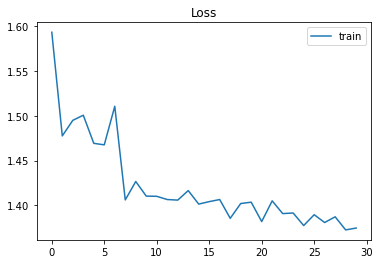

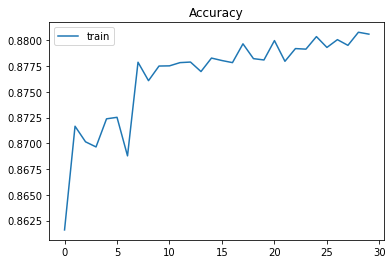

In [94]:
# 绘图
import matplotlib.pyplot as plt
# Loss curve
plt.plot(train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.title('Accuracy')
plt.legend(['train'])
plt.savefig('acc.png')
plt.show()

In [91]:
print(w)
print(len(train_acc))

[ 1.00900713e-01 -3.24453682e-04  2.41328572e-02 -1.29736373e-02
  1.52322663e-03  4.41598183e-03 -8.10023568e-03 -6.30979321e-03
  1.09660619e-02 -1.55217480e-02 -5.05360256e-03  7.92284628e-04
 -3.87286996e-03  1.79833980e-02 -4.50317266e-04  7.76168514e-04
  6.45179379e-03 -6.35924211e-03  1.49940565e-03 -1.39146012e-02
 -3.26905587e-03  6.87819997e-03 -3.52416702e-03  2.50291503e-03
  8.88451944e-03 -1.52308986e-03 -8.18325022e-03  2.49629623e-03
  2.41451780e-03  2.20256257e-03 -9.54040736e-03 -9.46487668e-03
 -5.51113002e-03  6.54847078e-03 -2.75873813e-03  1.11716493e-02
  1.43115179e-02 -6.25621063e-03 -1.10247437e-03 -2.08649775e-03
 -2.53018327e-04  2.05881839e-02  3.23268574e-04 -3.16454961e-04
 -1.38143254e-02  2.09658138e-03  1.01531645e-03 -1.55778517e-03
 -2.04784452e-03  2.21785635e-03  5.61687217e-03  5.50149343e-03
 -7.88606878e-03 -8.01203230e-03 -5.96902984e-03  3.86606185e-03
 -1.75672401e-03  1.56787650e-03 -5.18072252e-03 -4.72256280e-03
 -6.27184150e-03  1.49039

In [96]:
# 在测试集上运行
predictions = _predict(X_test, w, b).astype(int)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Italy -0.7186299977482026
num persons worked for employer 0.43799159171076085
 Grandchild 18+ never marr RP of subfamily -0.4032477187279099
 Child under 18 ever married -0.40061350653687255
 2 -0.4000520712070334
 High school graduate -0.3995633260291326
 Neither parent present -0.38700571921575294
 Other Rel 18+ ever marr RP of subfamily -0.34707299843736633
 No 0.34000306020221394
 Vietnam -0.21867981727955152
